# Implementation of new curtailment constraints in MESSAGEix-GLOBIOM

Load modules:

In [1]:
import message_ix
import ixmp as ix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
from message_ix.utils import make_df
from itertools import product
from timeit import default_timer as timer
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from scripts.functions_for_message_implementation import *

%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

### Steps taken:
1. Read curtailment parameters derived from PyPSA-Eur
2. Load scenario in MESSAGEix-GLOBIOM
3. Convert retained technology contributions to new data structure
4. Technology linkage (adding SDES and LDES)
5. Add curtailment technologies and relations to the scenario
6. Solve scenario

Settings:

In [2]:
replace_stor_ppl = True # whether to replace "stor_ppl" with more distinct groups of storage, shot-duration energy storage "SDES" and long-duration energy storage "LDES".

###############################
increase_number_of_bins = True # whether to increase the number of bins for the curtailment parameters from 3 bins to 7 bins for both wind and solar
###############################

wind_solar_complimentarity = False # whether to add 2-dimensional penetration bins

change_structure = False # whether the curtailment relation is restructured such that it contains more bins and furthermore is decomposed into a base curtailment ("wind_curtailment_x" and "solar_curtailment_y")
                         # and an actual curtailment accounting for the technology impact ("vre_curtailment_xy").

keep_curtailment = False # whether to keep current curtailment parameters - but in a restructured way such that it fits with our new approach (only used for testing)

shift_beta = False # whether the first non-zero technology impact is shifted to the first bin such that the first bin is not zero (only used for testing)

### Step 1) fetch curtailment parameters

Read parameters derived from PyPSA-Eur scenarios and collect them in dictionaries:

In [3]:
# gamma coefficients (marginal curtailment rates)
path = "parameters/"
gamma_ij_wind = pd.read_csv(path + "gamma_ij_wind_primary.csv",index_col=0).dropna()
gamma_ij_solar = pd.read_csv(path + "gamma_ij_solar_primary.csv",index_col=0).dropna()

# beta coefficients (counter acting term from renewable integration support measures)
techs = ["LDES","SDES"] # technologies for which coefficients are fetched from PyPSA-Eur scenarios
beta_tech_wind = {}
beta_tech_solar = {}
beta_tech_aggr = {}
for tech in techs:
    df_read_w = pd.read_csv(path + "beta_"+tech+"_wind.csv",index_col=0).dropna()
    df_read_s = pd.read_csv(path + "beta_"+tech+"_solar.csv",index_col=0).dropna()

    if shift_beta:
        df_read_w.loc["wind_curtailment_w0s0"] = df_read_w.loc["wind_curtailment_w1s0"]
        df_read_w.loc["wind_curtailment_w1s0"] = 0

        df_read_s.loc["solar_curtailment_s0w0"] = df_read_s.loc["solar_curtailment_s1w0"]
        df_read_s.loc["solar_curtailment_s1w0"] = 0

    beta_tech_wind[tech] = df_read_w
    beta_tech_solar[tech] = df_read_s

# renewable shares
wind_shares_pypsa = pd.read_csv(path + "wind_shares.csv",index_col=0).loc[gamma_ij_wind.index]
solar_shares_pypsa = pd.read_csv(path + "solar_shares.csv",index_col=0).loc[gamma_ij_solar.index]

# create dictionaries that contain the parameters
gamma_dict = gamma_ij_solar.to_dict()["0"]
gamma_wind_dict = gamma_ij_wind.to_dict()["0"]
gamma_dict.update(gamma_wind_dict) # dictionary containing all gamma coefficients

renewable_penetration_dict = solar_shares_pypsa.to_dict()["0"]
wind_penetration = wind_shares_pypsa.to_dict()["0"]
renewable_penetration_dict.update(wind_penetration)

df_beta_solar_LDES, df_beta_solar_SDES, df_beta_wind_LDES, df_beta_wind_SDES, df_gamma_wind, df_gamma_solar = add_solar_wind_share_to_df(beta_tech_solar, beta_tech_wind, gamma_ij_wind, gamma_ij_solar)

For visualization purpose, we show the parameters for wind and solar base curtailment as well as the technology parameters for SDES and LDES:

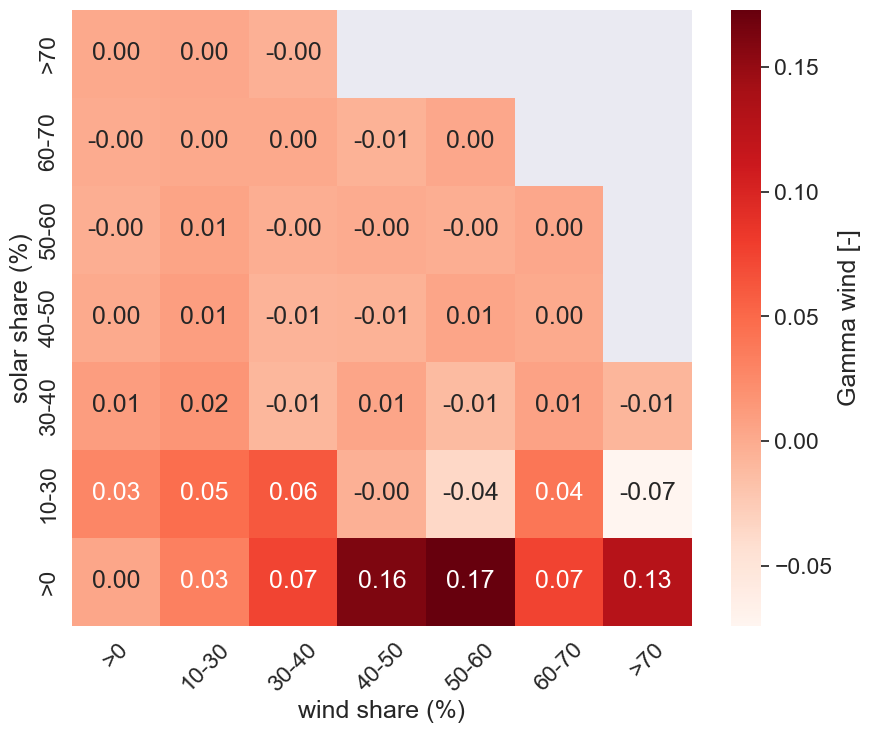

In [4]:
# color plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_gamma_wind, annot=True, ax=ax, cmap="Reds", cbar_kws={'label': 'Gamma wind [-]'},fmt='.2f')

ticklabels = [">0", "10-30", "30-40", "40-50", "50-60", "60-70", ">70"]
ax.set_xticks(np.arange(len(ticklabels))+0.5)
ax.set_xticklabels(ticklabels,rotation=45)
ax.set_yticks(np.arange(len(ticklabels))+0.5)

# change order of ticklabels
ticklabels = ticklabels[::-1]
ax.set_yticklabels(ticklabels)
ax.set_xlabel("wind share (%)",fontsize=18)
ax.set_ylabel("solar share (%)",fontsize=18)

plt.show()

fig.savefig("figures/gamma_wind.png",dpi=300,bbox_inches="tight")


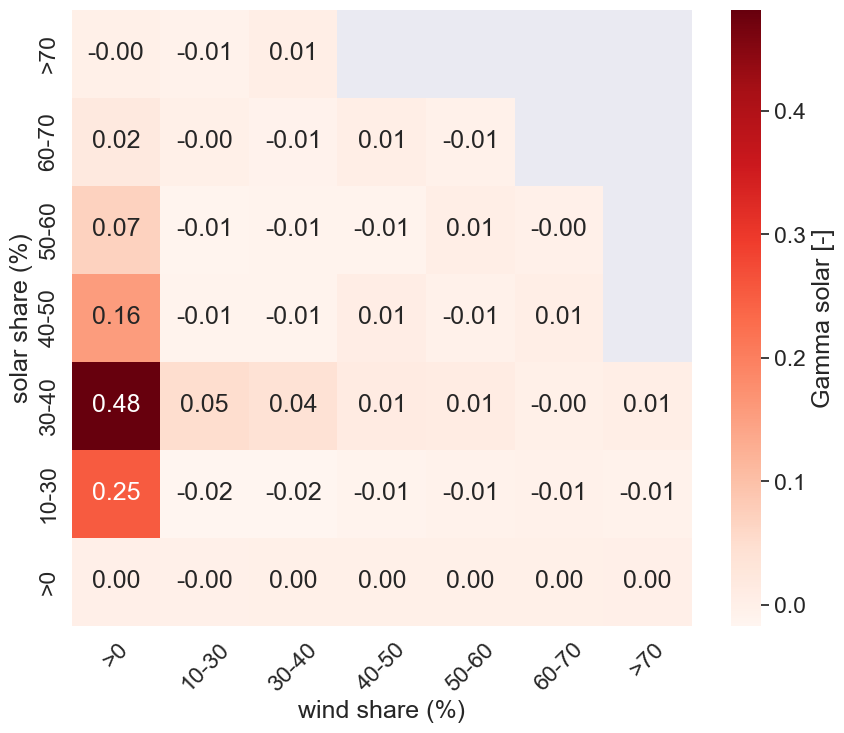

In [5]:
# color plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_gamma_solar, annot=True, ax=ax, cmap="Reds", cbar_kws={'label': 'Gamma solar [-]'},fmt='.2f')

ticklabels = [">0", "10-30", "30-40", "40-50", "50-60", "60-70", ">70"]
ax.set_xticks(np.arange(len(ticklabels))+0.5)
ax.set_xticklabels(ticklabels,rotation=45)
ax.set_yticks(np.arange(len(ticklabels))+0.5)

# change order of ticklabels
ticklabels = ticklabels[::-1]
ax.set_yticklabels(ticklabels)
ax.set_xlabel("wind share (%)",fontsize=18)
ax.set_ylabel("solar share (%)",fontsize=18)

plt.show()

fig.savefig("figures/gamma_solar.png",dpi=300,bbox_inches="tight")


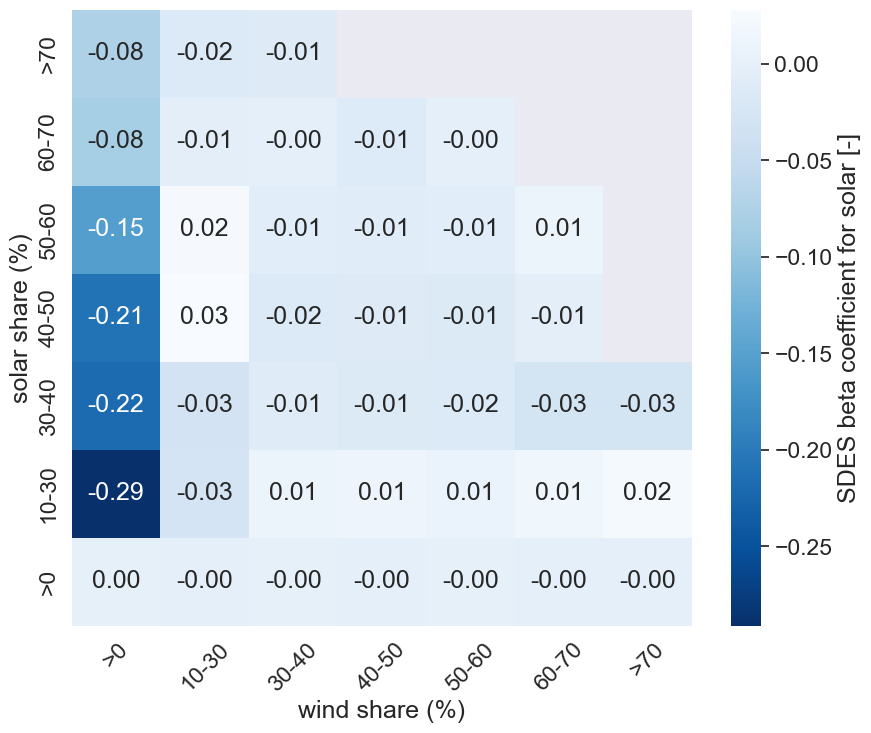

In [6]:
# color plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_beta_solar_SDES, annot=True, ax=ax, cmap="Blues_r", cbar_kws={'label': 'SDES beta coefficient for solar [-]'},fmt='.2f')

ticklabels = [">0", "10-30", "30-40", "40-50", "50-60", "60-70", ">70"]
ax.set_xticks(np.arange(len(ticklabels))+0.5)
ax.set_xticklabels(ticklabels,rotation=45)
ax.set_yticks(np.arange(len(ticklabels))+0.5)

# change order of ticklabels
ticklabels = ticklabels[::-1]
ax.set_yticklabels(ticklabels)
ax.set_xlabel("wind share (%)",fontsize=18)
ax.set_ylabel("solar share (%)",fontsize=18)

plt.show()

fig.savefig("figures/beta_solar_SDES.png",dpi=300,bbox_inches="tight")


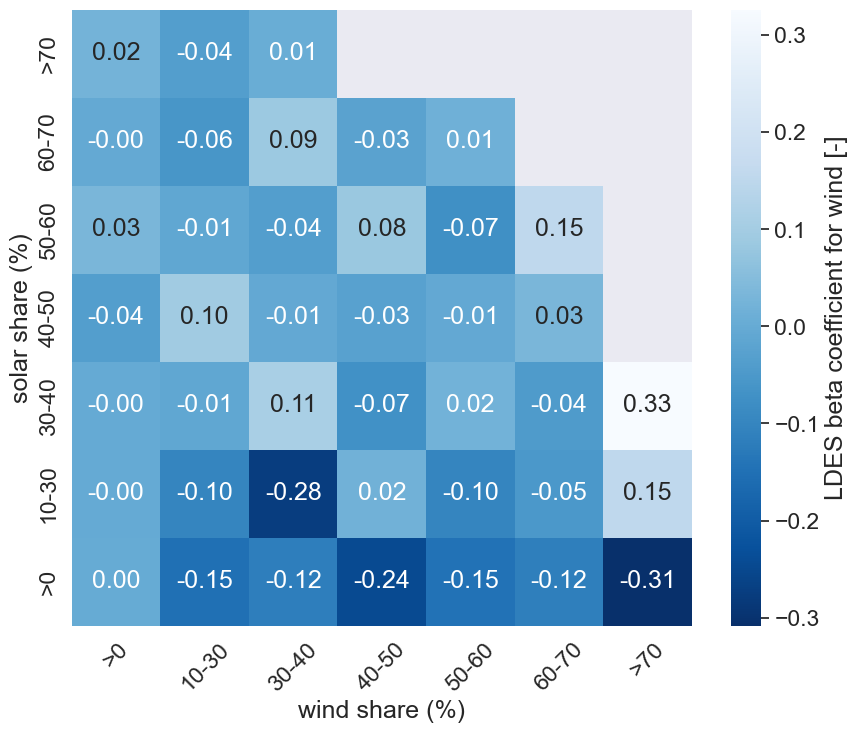

In [7]:
# color plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_beta_wind_LDES, annot=True, ax=ax, cmap="Blues_r", cbar_kws={'label': 'LDES beta coefficient for wind [-]'},fmt='.2f')

ticklabels = [">0", "10-30", "30-40", "40-50", "50-60", "60-70", ">70"]
ax.set_xticks(np.arange(len(ticklabels))+0.5)
ax.set_xticklabels(ticklabels,rotation=45)
ax.set_yticks(np.arange(len(ticklabels))+0.5)

# change order of ticklabels
ticklabels = ticklabels[::-1]
ax.set_yticklabels(ticklabels)
ax.set_xlabel("wind share (%)",fontsize=18)
ax.set_ylabel("solar share (%)",fontsize=18)

plt.show()

fig.savefig("figures/beta_wind_LDES.png",dpi=300,bbox_inches="tight")


### Step 2) load scenario in MESSAGEix-GLOBIOM

In [8]:
# load ixmp database
mp = ix.Platform('local',jvmargs=["-Xmx8G"])
solve_scenario = True # if True, solving scenario at the end
regions = ["R11_WEU", "R11_EEU"]

# reference scenario: 
opts = "remove_all_but_curtailment"
sc_ref = message_ix.Scenario(mp, 
                             model="MESSAGEix-GLOBIOM", 
                             scenario="ENGAGE_SSP2_EN_NPi2020_500_" + opts)

model = "MESSAGEix-GLOBIOM"
scen = "ENGAGE_SSP2_EN_NPi2020_500_PyPSA_Eur_1D_" + opts

# clone scenario and add modifications
sc = sc_ref.clone(model=model, scenario=scen, keep_solution=False)

sc.check_out()

years = sc.set('year')

# technology contributing to the curtailment relations that have not yet been parameterized from PyPSA-Eur scenarios
message_techs_in_curtailment_rels =  ["elec_trp",
                                      "h2_elec",
                                      "elec_exp_eurasia",
                                      "elec_imp_eurasia",
                                      "elec_exp_eur_afr",
                                      "elec_imp_eur_afr"]

if not replace_stor_ppl:
    message_techs_in_curtailment_rels += ["stor_ppl"]

technologies = {
    "solar": [x for x in set(sc_ref.set("technology")) if any([y in x for y in ["solar_res"]])], 
    "wind": [x for x in set(sc_ref.set("technology")) if any([y in x for y in ["wind_res", "wind_ref"]])], 
    "wind curtailed": [x for x in set(sc_ref.set("technology")) if "wind_curt" in x],
    "solar curtailed": [x for x in set(sc_ref.set("technology")) if "solar_curt" in x],
    }

parname = "relation_activity"

Adjust according to settings:

In [9]:
# to test if the softlink is working expectedly, we can run a scenario where we are using the new structure 
# (splitting the curtailment relations into "VRE_curtailment_{ij}" and "wind_curtailment_{ij}" and 
# "solar_curtailment_{ij}" relations - but with the original curtailment parameters retained. 
# The new structure furthermore uses 7 x 7 - 8 bins for both wind and solar curtailment instead of 1 x 3 bins.
if keep_curtailment:
    gamma_ij_wind = keep_existing_curtailment_rates(sc_ref, "wind", gamma_ij_wind, gamma_ij_solar)
    gamma_ij_solar = keep_existing_curtailment_rates(sc_ref, "solar", gamma_ij_wind, gamma_ij_solar)

### Step 3) Keep technology curtailment parameters from original formulation

Make dictionary containing all beta coefficients, both the ones derived from PyPSA-Eur scenarios and the existing ones present in the original representation in MESSAGEix-GLOBIOM:

In [10]:
beta_tech_wind_extended = keep_existing_tech_contributions(sc_ref, message_techs_in_curtailment_rels, "wind", beta_tech_wind, shift_beta)
beta_tech_solar_extended = keep_existing_tech_contributions(sc_ref, message_techs_in_curtailment_rels, "solar", beta_tech_solar, shift_beta)

if not replace_stor_ppl:
    beta_tech_wind_extended.pop("LDES") # remove "LDES" from beta_tech_wind_extended
    beta_tech_wind_extended.pop("SDES") # remove "SDES" from beta_tech_wind_extended

beta_dict = {}
for tech in beta_tech_wind_extended.keys():
    
    dict_w = beta_tech_wind_extended[tech].to_dict()
    beta_dict["wind", tech] = dict_w[list(dict_w.keys())[0]]

    dict_s = beta_tech_solar_extended[tech].to_dict()
    beta_dict["solar", tech] = dict_s[list(dict_s.keys())[0]]

### Step 4) Technology linkage

Here, we replace the generic storage power plant "**stor_ppl**" with a short-duration "**SDES**" and long-duration "**LDES**" electricity storage. 

**LDES**
- duration (E/G_d): 50 hrs (variable)
- Efficiency (round-trip): 0.48
- Technology cost: 
    - Charge link: 450 EUR/kW (+ 2% FOM)
    - Storage: 12 EUR/kWh (+ 2% FOM)
    - Discharge link: 500 EUR/kW (+ 2% FOM) 
    
    Aggregated cost: 1/efficiency * 450 EUR/kW + duration * 12 EUR/kWh + 500 EUR/kW = 2,037.5 EUR/kW
- Capacity factor: 20.5% (variable)
- Lifetime: 20 years

**SDES**
- duration (E/G_d): 6 hrs (variable)
- Efficiency (round-trip): 0.94
- Technology cost: 
    - Charge link (battery inverter/converter): 160 EUR/kW
    - Storage: 142 EUR/kWh
    - Discharge link: 0 EUR/kW
    
    Aggregated cost: 1/effficiency * 160 EUR/kW + duration * 142 EUR/kWh + 0 EUR/kW = 1,022 EUR/kW
- Capacity factor: 11.9% (variable)
- Lifetime: 25 years


In MESSAGEix-GLOBIOM, the storage tech needs to have the following attributes defined:
- input electricity (par)
- output (par)
- inv_cost (par)
- technology (set)
- var_cost (par)
- technical_lifetime (par)
- capacity_factor (par)


Storage technology attributes from PyPSA-Eur:

In [11]:
# inputs
efficiency_ldes = 0.48 # round-trip efficiency of LDES
c_c_ldes = 450 # EUR/kW
c_hat_ldes = 12 # EUR/kWh
c_d_ldes = 500 # EUR/kW
ldes_lifetime = 20 # years

efficiency_sdes = 0.94 # round-trip efficiency of LDES
c_c_sdes = 160 # EUR/kW
c_hat_sdes = 142 # EUR/kWh
c_d_sdes = 0 # EUR/kW
sdes_lifetime = 25 # years

# read outputs from PyPSA-Eur concerning storage capacity and operation
path = "calculated_metrics/new_SDES_LDES_co2_lim/"

# duration (i.e., the ratio of energy capacity and discharge power capacity)
duration_ldes = pd.read_csv(path + "LDES_duration.csv",index_col=[0,1]) # LDES duration [hours]
duration_ldes_avg = duration_ldes.mean().item() # average over all wind-solar combinations 
duration_sdes = pd.read_csv(path + "SDES_duration.csv",index_col=[0,1]) # SDES duration [hours]
duration_sdes_avg = duration_sdes.mean().item() # average over all wind-solar combinations

# capacity factor (i.e., utilization rate of installed capacity)
ldes_capacity_factor = pd.read_csv(path + "LDES_capacity_factor.csv",index_col=[0,1]) # LDES CF [%]
ldes_capacity_factor_avg = ldes_capacity_factor[ldes_capacity_factor > 0].mean().item() # average over all wind-solar combinations
sdes_capacity_factor = pd.read_csv(path + "SDES_capacity_factor.csv",index_col=[0,1]) # LDES CF [%]
sdes_capacity_factor_avg = sdes_capacity_factor[sdes_capacity_factor > 0].mean().item() # average over all wind-solar combinations

# other features not used to calculate costs but relevant for comparison:
ldes_no_cycles = pd.read_csv(path + "LDES_no_cycles.csv",index_col=[0,1]) # LDES number of cycles
ldes_no_cycles_avg = ldes_no_cycles.mean().item() # average over all wind-solar combinations
sdes_no_cycles = pd.read_csv(path + "SDES_no_cycles.csv",index_col=[0,1]) # SDES number of cycles
sdes_no_cycles_avg = sdes_no_cycles.mean().item() # average over all wind-solar combinations
ldes_dod = pd.read_csv(path + "LDES_dod.csv",index_col=[0,1]) # LDES depth of discharge
ldes_dod_avg = ldes_dod.mean().item() # average over all wind-solar combinations
sdes_dod = pd.read_csv(path + "SDES_dod.csv",index_col=[0,1]) # SDES depth of discharge
sdes_dod_avg = sdes_dod.mean().item() # average over all wind-solar combinations

# aggregated cost:
ldes_inv_cost = 1/efficiency_ldes*c_c_ldes + duration_ldes*c_hat_ldes + c_d_ldes # EUR/kW
sdes_inv_cost = 1/efficiency_sdes*c_c_sdes + duration_sdes*c_hat_sdes + c_d_sdes # EUR/kW # 1022 # EUR/kW

ldes_inv_cost_avg = ldes_inv_cost.loc[ldes_capacity_factor[ldes_capacity_factor > 0].dropna().index].mean().item()
sdes_inv_cost_avg = sdes_inv_cost.loc[sdes_capacity_factor[sdes_capacity_factor > 0].dropna().index].mean().item()

Add storage technologies to the scenario:

In [12]:
if replace_stor_ppl:
    for region in regions:
        add_storage_tech(sc, sc_ref, "LDES", years, ldes_capacity_factor_avg, ldes_inv_cost_avg, ldes_lifetime, efficiency_ldes, region, df_beta_solar_SDES, df_beta_solar_LDES, df_beta_wind_LDES, df_beta_wind_SDES, change_structure)
        add_storage_tech(sc, sc_ref, "SDES", years, sdes_capacity_factor_avg, sdes_inv_cost_avg, sdes_lifetime, efficiency_sdes, region, df_beta_solar_SDES, df_beta_solar_LDES, df_beta_wind_LDES, df_beta_wind_SDES, change_structure)

Now that we have added LDES and SDES as technologies and copied the parameters from the firm capacity and flexibility constraints for stor_ppl (only in Western Europe), we will remove "*stor_ppl*" from these two constraints:

In [13]:
if replace_stor_ppl:
    # Removing "stor_ppl" from the firm capacity constraint (res_marg)
    df_res_marg = sc.par("relation_total_capacity", 
                        {"relation":"res_marg",
                        "technology":"stor_ppl",
                        "node_rel":regions})
    sc.remove_par("relation_total_capacity", df_res_marg)

    # Removing "stor_ppl" from the flexibility constraint (oper_res)
    df_oper_res = sc.par("relation_activity", 
                        {"relation":"oper_res",
                        "technology":"stor_ppl",
                        "node_rel":regions})
    sc.remove_par("relation_activity", df_oper_res)

    # Removing "stor_ppl" from the curtailment constraint
    df_stor_ppl_curtailment = sc.par("relation_activity", 
                                    {"relation":["wind_curtailment_1","wind_curtailment_2","wind_curtailment_3",
                                                "solar_curtailment_1","solar_curtailment_2","solar_curtailment_3"],
                                    "technology":"stor_ppl",
                                    "node_rel":regions})
    sc.remove_par("relation_activity", df_stor_ppl_curtailment)

### Step 5) Add curtailment technologies and relations to the scenario

Initialize curtailment relations:

In [14]:
curt_relation_tech, bins_dict, new_bins, curt_relation = add_curtailment_techs(renewable_penetration_dict, beta_dict, gamma_ij_wind, gamma_ij_solar, replace_stor_ppl)

if not change_structure:
    new_bins = None
    curt_relation = None

{'vre_curtailment_w1s1': [{'wind_curtailment1': 0.0037371249171338, 'solar_curtailment1': 0.002290072586197, 'elec_trp': 0.0, 'h2_elec': 0.0, 'elec_exp_eurasia': 0.0, 'elec_imp_eurasia': 0.0, 'elec_exp_eur_afr': 0.0, 'elec_imp_eur_afr': 0.0, 'LDES': 0.0, 'SDES': 0.0}], 'vre_curtailment_w1s2': [{'wind_curtailment1': 0.0276494369460103, 'solar_curtailment2': 0.2527864681633947, 'elec_trp': -0.2, 'h2_elec': -0.7052631578947369, 'elec_exp_eurasia': -1.2652631578947369, 'elec_imp_eurasia': -0.705263157894737, 'elec_exp_eur_afr': -1.2652631578947369, 'elec_imp_eur_afr': -0.705263157894737, 'LDES': -0.046101324745595196, 'SDES': -0.3050250462972438}], 'vre_curtailment_w1s3': [{'wind_curtailment1': 0.0097918369226165, 'solar_curtailment3': 0.4818535505889985, 'elec_trp': 0.0, 'h2_elec': 0.0, 'elec_exp_eurasia': 0.0, 'elec_imp_eurasia': 0.0, 'elec_exp_eur_afr': 0.0, 'elec_imp_eur_afr': 0.0, 'LDES': 0.0400177688060895, 'SDES': -0.2209158072357206}], 'vre_curtailment_w1s4': [{'wind_curtailment1':

In [15]:
if change_structure and not wind_solar_complimentarity:
    df_bins = pd.DataFrame()
    df_bins["bins"] = new_bins.keys()
    df_bins["solar"] = df_bins.bins.str.split("s",expand=True)[1].astype(int)
    df_bins["wind"] = df_bins.bins.str.split("s",expand=True)[0].str.split("w",expand=True)[1].astype(int)
    df_bins_solar_only = df_bins.query("wind == 1")
    df_bins_wind_only = df_bins.query("solar == 1")
    bins_wind_only = list(df_bins_wind_only.bins.values)
    bins_solar_only = list(df_bins_solar_only.bins.values)
    bins_combined = bins_wind_only + bins_solar_only

    # access all items in new_bins that match bins_combined
    new_bins_reduced = {k: new_bins[k] for k in bins_combined}

    # access all items in curt_relation that match bins_combined
    curt_relation_reduced = {k: curt_relation[k] for k in bins_combined}

    new_bins = new_bins_reduced
    curt_relation = curt_relation_reduced

In [16]:
if change_structure:
    # Curtailment relations and technologies (for checking)
    curtail_relations = [x for x in set(sc.set("relation")) if "curtailment" in x]
    curtail_techs = [x for x in set(sc.set("technology")) if "curtailment" in x]

    # Add wind/solar curtailment data for new bins (not present in the old data)
    new_relations = [x for x in bins_dict.keys() if x not in set(sc.set("relation"))]
    new_techs = [curt_relation_tech[x] for x in new_relations]

    # Add new set elements to the scenario
    sc.add_set("technology", new_techs) # here, new technologies cover the ones for "wind_curtailment_{}" and "solar_curtailment_{}".
    sc.add_set("relation", new_relations) # here, new relations cover the ones for "wind_curtailment_{}" and "solar_curtailment_{}".

    print("Added new technologies: ", new_techs)
    print("Added new relations: ", new_relations)

    add_curtailment_relations(sc, sc_ref, bins_dict, regions, curt_relation_tech, parname)

    # remove technology contributions from base curtailment relations
    for region in regions:
        df_tech_contrib = sc.par("relation_activity",
                                {"node_loc": region,
                                "relation": curt_relation_tech.keys(),
                                "technology": message_techs_in_curtailment_rels})

        sc.remove_par("relation_activity",df_tech_contrib)

    # Add new bins to the set of relations and new technologies to technology in the scenario:
    add_new_bins(sc, new_bins, parname, curt_relation, curt_relation_tech, regions, years)

In [17]:
if increase_number_of_bins and not wind_solar_complimentarity and not change_structure:
    # get parameters for wind only and solar only from PyPSA-Eur
    gamma_ij_wind_cp = gamma_ij_wind.copy()
    gamma_ij_wind_cp["index"] = gamma_ij_wind_cp.index
    gamma_ij_wind_only_wind_dict = split_wind(gamma_ij_wind_cp, gamma_ij_wind.columns[0])
    gamma_ij_solar_cp = gamma_ij_solar.copy()
    gamma_ij_solar_cp["index"] = gamma_ij_solar_cp.index
    gamma_ij_solar_only_solar_dict = split_solar(gamma_ij_solar_cp, gamma_ij_solar.columns[0])
    gamma_ij_solar_only_solar_dict.update(gamma_ij_wind_only_wind_dict)
    
    old_curtailment_techs = technologies["wind curtailed"] + technologies["solar curtailed"]
    new_curtailment_techs = [x for x in gamma_ij_solar_only_solar_dict.keys() if x not in old_curtailment_techs]
    curt_relation_tech_rev = {v: k for k, v in curt_relation_tech.items()}
    new_curtailment_relations = [curt_relation_tech_rev[x] for x in new_curtailment_techs]

    sc.add_set("relation", new_curtailment_relations)
    sc.add_set("technology", new_curtailment_techs)

    ############################### ADD INPUTS ###################################################
    df_input_old = sc.par("input",
                        {"node_loc": regions,
                        "technology": old_curtailment_techs,
                        "year_vtg": years,
                        "year_act": years,
                        })

    sc.remove_par("input",df_input_old)
    # add new inputs for wind curtailment4, wind_curtailment5, ..., and solar_curtailment4, solar_curtailment5, ... 
    for curt_t,region in product(gamma_ij_solar_only_solar_dict.keys(), regions):
        df_input = make_df('input',
                            node_loc = region,
                            technology = curt_t,
                            year_vtg=years,
                            year_act=years,
                            mode="M1",
                            node_origin=region,
                            commodity="electr",
                            level="secondary",
                            time="year",
                            time_origin="year",
                            value = gamma_ij_solar_only_solar_dict[curt_t],
                            unit = "GWa")
        
        sc.add_par('input',df_input)

In [18]:
if increase_number_of_bins and not wind_solar_complimentarity and not change_structure:
    ################################### RELATION ACTIVITY 1/2 #########################################
    ################################ - add new curtailment relations ##################################
    new_wind_curt_rel = [x for x in new_curtailment_relations if "wind" in x]
    new_solar_curt_rel = [x for x in new_curtailment_relations if "solar" in x]

    df_relation_activity_wind_cp = sc.par("relation_activity",
                                            {"relation":"wind_curtailment_3",
                                            "node_rel":regions,
                                            "year_rel":years,
                                            })

    for i in new_wind_curt_rel:
        df_relation_activity_wind_cp_i = df_relation_activity_wind_cp.copy()
        df_relation_activity_wind_cp_i["relation"] = i
        df_relation_activity_wind_cp_i["technology"] = df_relation_activity_wind_cp_i.technology.replace({"wind_curtailment3":curt_relation_tech[i]})

        sc.add_par('relation_activity',df_relation_activity_wind_cp_i)

    df_relation_activity_solar_cp = sc.par("relation_activity",
                                            {"relation":"solar_curtailment_3",
                                            "node_rel":regions,
                                            "year_rel":years,
                                            })

    for i in new_solar_curt_rel:
        df_relation_activity_solar_cp_i = df_relation_activity_solar_cp.copy()
        df_relation_activity_solar_cp_i["relation"] = i
        df_relation_activity_solar_cp_i["technology"] = df_relation_activity_solar_cp_i.technology.replace({"wind_curtailment3":curt_relation_tech[i]})

        sc.add_par('relation_activity',df_relation_activity_solar_cp_i)

In [19]:
if increase_number_of_bins and not wind_solar_complimentarity and not change_structure:
    ################################### RELATION ACTIVITY 2/2 #########################################
    ############################ - update values in new curtailment relations #########################

    df_relation_activity_old = sc.par("relation_activity",
                                    {"node_loc": regions,
                                    "relation": curt_relation_tech.keys(),
                                    "technology": beta_tech_wind_extended.keys(),
                                    "year_rel": years,
                                    "year_act": years,
                                    })

    sc.remove_par("relation_activity",df_relation_activity_old) # removing technology parameters from the curtailment relations

    for curt_r, region, tech in product(curt_relation_tech.keys(), regions, beta_tech_wind_extended.keys()): 

        beta_all_dict = {}
        df = pd.DataFrame()
        df["index"] = beta_dict["wind",tech].keys()
        df["val"] = beta_dict["wind",tech].values()
        beta_wind_only_dict = split_wind(df, "val", "_")
        beta_all_dict.update(beta_wind_only_dict)

        df = pd.DataFrame()
        df["index"] = beta_dict["solar",tech].keys()
        df["val"] = beta_dict["solar",tech].values()
        beta_solar_only_dict = split_solar(df, "val", "_")
        beta_all_dict.update(beta_solar_only_dict)

        df_relation_activity = make_df('relation_activity',
                                    relation = curt_r,
                                    node_rel = region,
                                    year_rel = years,
                                    node_loc = region,
                                    technology = tech,
                                    year_act = years,
                                    mode = "M1",
                                    value = beta_all_dict[curt_r],
                                    unit = "???"
                                    )

        sc.add_par('relation_activity',df_relation_activity) # adding a new relation for the technology considered

In [20]:
if increase_number_of_bins and not wind_solar_complimentarity and not change_structure:
    ##########################¤¤¤¤¤¤¤¤¤ PENETRATION LEVEL ##########################################
    df = wind_shares_pypsa.copy()
    df["index"] = df.index
    wind_bins_dict = split_wind(df, "0", "_")

    df = solar_shares_pypsa.copy()
    df["index"] = df.index
    solar_bins_dict = split_solar(df, "0", "_")
    solar_bins_dict.update(wind_bins_dict)

    df_relation_activity_old = sc.par("relation_activity",
                                        {"node_rel": region,
                                        "relation": curt_relation_tech.keys(),
                                        "technology": "elec_t_d",
                                        "year_rel": years,
                                        "year_act": years,
                                        })

    sc.remove_par("relation_activity",df_relation_activity_old) # removing old penetration levels

    for curt_r, region in product(curt_relation_tech.keys(),regions):

        df_relation_activity = make_df('relation_activity',
                                        relation = curt_r,
                                        node_rel = region,
                                        year_rel = years,
                                        node_loc = region,
                                        technology = "elec_t_d",
                                        year_act = years,
                                        mode = "M1",
                                        value = -solar_bins_dict[curt_r],
                                        unit = "???"
                                        )

        sc.add_par('relation_activity',df_relation_activity) # adding new penetration levels

Remove the contribution from stor_ppl as it has been replaced by LDES and SDES:

In [21]:
if change_structure:
    for region in regions:
        df = sc.par("relation_activity",
                    {"node_loc": region, 
                    "technology": "stor_ppl"})

        sc.remove_par("relation_activity", df)

In [22]:
sc.commit("Curtailment updated")

### Step 6) Solve scenario

In [23]:
if solve_scenario:
    #case = sc.model + '__' + sc.scenario + '__v' + str(sc.version)
    print(f'Solving scenario "{scen}", please wait...!')

    start = timer()
#     sc.solve(model='MESSAGE', case=case)
    sc.solve(solve_options={"lpmethod": "4",
                            "advind":"0",
                            "lpmethod":"4","threads":"4", 
                            "epopt":"1e-06",
                            "scaind":"-1"})

    end = timer()
    print('Elapsed time for solving scenario:', int((end - start)/60),
          'min and', round((end - start) % 60, 2), 'sec.')
    sc.set_as_default()

Solving scenario "ENGAGE_SSP2_EN_NPi2020_500_PyPSA_Eur_1D_remove_all_but_curtailment", please wait...!
Elapsed time for solving scenario: 179 min and 37.1 sec.


In [24]:
mp.close_db()